# Purpose of this notebook

This notebook will be to look at a basin by basin breakdown of the volume distribution and see differences between two example years. We will also try to color these in different color scales by the water mass name.

# Import packages and functions

In [27]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh
from plotting_helpers import *           # truncate_colormap

In [2]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# set the grid, months, mask of interest

In [3]:
# iB = 6
m = 0
s = 1
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [6]:
# read one basin or whole ASTE
whole = True
if not whole:
    iB = 6    # example read from BarentsSea

In [7]:
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
if whole:
    mask = (mymsk < 5) | (mymsk==6) 
else:
    mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


# Read the files

We need:
- theta and salt
- volume from the grid and ETAN

In [9]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
# times["2014"] = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
times["2014"] = np.array([3,9])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt = np.array([])
for i in range(1,len(datetimes)):
    dt = np.append(dt,(datetimes[i]-datetimes[i-1]).total_seconds())

In [10]:
file_name = 'budg3d_snap_set2'
THETADR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["THETADR"]),mymsk,dirIn)
SALTDR = read_field3d(tsstr,nz,ny,nx,file_name,np.array(["SALTDR"]),mymsk,dirIn)

# divide first two and second two by dt
theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)

for i in range(len(tsstr)):
    theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
    salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']

for i in range(len(tsstr)-1):
    dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
    dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]

In [11]:
# first have to get the vector values from U and V
file_name = "budg3d_hflux_set2"
UVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['UVELMASS']),mymsk,dirIn)
VVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['VVELMASS']),mymsk,dirIn)
ADVx_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_TH']),mymsk,dirIn)     # degC m^3/s
ADVy_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_TH']),mymsk,dirIn)
DFxE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_TH']),mymsk,dirIn)
DFyE_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_TH']),mymsk,dirIn)
ADVx_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVx_SLT']),mymsk,dirIn)   # PSU m^3/s
ADVy_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVy_SLT']),mymsk,dirIn)
DFxE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFxE_SLT']),mymsk,dirIn)
DFyE_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['DFyE_SLT']),mymsk,dirIn)

# get the vectors of u and v without mass weighting
Uo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
Vo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_THo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVx_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
ADVy_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFxE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)
DFyE_SLTo = np.full((int(len(tsstr)),nz,ny-nfy[0],nfx[0]*2),np.nan)

for i in range((int(len(tsstr)))):
    # get values from reading before
    tmpU = UVELMASS[i]
    tmpV = VVELMASS[i]
    tmpUadvth = ADVx_TH[i]
    tmpVadvth = ADVy_TH[i]
    tmpUdfth = DFxE_TH[i]
    tmpVdfth = DFyE_TH[i]
    tmpUadvslt = ADVx_SLT[i]
    tmpVadvslt = ADVy_SLT[i]
    tmpUdfslt = DFxE_SLT[i]
    tmpVdfslt = DFyE_SLT[i]

    # define u and v velocities
    tmpUo,tmpVo = get_aste_vector_face1_3(tmpU,tmpV,nfx,nfy,False)
    tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]     # centering
    # define in theta
    tmpUadvth,tmpVadvth = get_aste_vector_face1_3(tmpUadvth,tmpVadvth,nfx,nfy,False)
    tmpUadvth,tmpVadvth = tmpUadvth[:,:-1,:-1],tmpVadvth[:,:-1,:-1]     # centering
    tmpUdfth,tmpVdfth = get_aste_vector_face1_3(tmpUdfth,tmpVdfth,nfx,nfy,False)
    tmpUdfth,tmpVdfth = tmpUdfth[:,:-1,:-1],tmpVdfth[:,:-1,:-1]     # centering
    # define in salt
    tmpUadvslt,tmpVadvslt = get_aste_vector_face1_3(tmpUadvslt,tmpVadvslt,nfx,nfy,False)
    tmpUadvslt,tmpVadvslt = tmpUadvslt[:,:-1,:-1],tmpVadvslt[:,:-1,:-1]     # centering
    tmpUdfslt,tmpVdfslt = get_aste_vector_face1_3(tmpUdfslt,tmpVdfslt,nfx,nfy,False)
    tmpUdfslt,tmpVdfslt = tmpUdfslt[:,:-1,:-1],tmpVdfslt[:,:-1,:-1]     # centering

    # add to larger arrays
    Uo[i] = tmpUo
    Vo[i] = tmpVo
    ADVx_THo[i] = tmpUadvth
    ADVy_THo[i] = tmpVadvth
    DFxE_THo[i] = tmpUdfth
    DFyE_THo[i] = tmpVdfth
    ADVx_SLTo[i] = tmpUadvslt
    ADVy_SLTo[i] = tmpVadvslt
    DFxE_SLTo[i] = tmpUdfslt
    DFyE_SLTo[i] = tmpVdfslt

In [30]:
file_name = "budg3d_zflux_set2"
WVELMASS = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['WVELMASS']),mymsk,dirIn)
ADVr_SLT = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_SLT']),mymsk,dirIn)
ADVr_TH = read_field3d(tsstr,nz,ny,nx,file_name,np.array(['ADVr_TH']),mymsk,dirIn)

In [12]:
# for mass tendency (m^3/s) - time is not yet included in this block
file_name = 'budg2d_snap_set1'

# assuming all files are structured the same
meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
# try to read this with rec
fldlist = np.array(meta_budg2d_snap_set1['fldList'])
varnames = np.array(['ETAN'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    t1 = tsstr[t]
    read = [int(t1)]

    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])

    # choose by basin
    ETAN = np.reshape(ETAN,(ny,nx))

    # ocean
    if debug:
        print(read,its[0],its[1]) # these iteration numbers should be the same as read

    # 3D, with rStar:
    tmpvol = np.zeros((nz, ny, nx))
    if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
        tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
        if myparms['useRFWF'] == 0:
            tmpvol[0, :, :] = np.zeros((ny, nx))
    else:    # 4/22 look at this one
        if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
            tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
            tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
        else:
            tmp2 = drf3d / mk3D_mod(DD, tmp1)

        # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
        tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) * mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))

print(vol.shape)

volume allocation shape (2, 50, 1350, 270)
(2, 50, 1350, 270)


# create the TS bins

In [13]:
# try new T bins where different sizes
refined_section = np.linspace(-3,8,93)
coarse_section = np.linspace(8,15,21,endpoint=False)
binsTH_edges = np.concatenate((refined_section,coarse_section[1:]))
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

# do bi-sectional form for S
coarse_section = np.linspace(0, 28, 30, endpoint=False)
refined_section = np.linspace(28, 40, 83)
binsSLT_edges = np.concatenate((coarse_section, refined_section))
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

In [14]:
# we want to bin theta and salt into the T and S bins
binned_theta = bin_array(theta,binsTH_edges)
binned_theta = binned_theta.astype(float)
binned_theta[binned_theta == nT] = np.nan     # because the binning is setting nan to last value
binned_salinity = bin_array(salt,binsSLT_edges)
binned_salinity = binned_salinity.astype(float)
binned_salinity[binned_salinity == nS] = np.nan

# loop through, look at basin by basin TS distribution

['CanadaB' 'ChukchiS' 'MakarovB' 'AmundsenB' 'NansenB' 'BeringS'
 'BarentsS']


(400.0, 860.0)

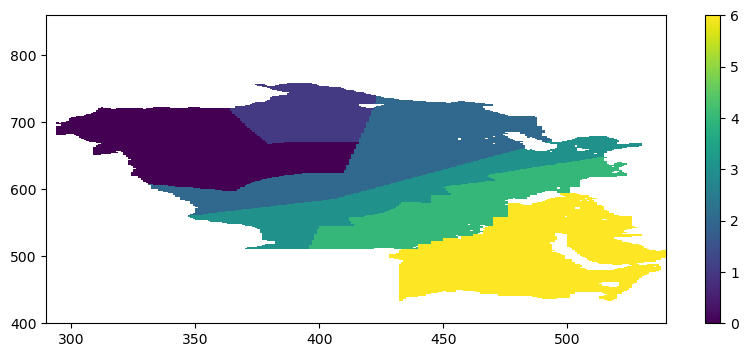

In [15]:
print(strb[0:7])
plt.pcolormesh(get_aste_tracer(mskBasin,nfx,nfy)[0] * get_aste_tracer(mymsk,nfx,nfy)[0])
maskArc = mskBasin * mymsk
plt.colorbar()
plt.xlim(290,540)
plt.ylim(400,860)

In [16]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap_bath = plt.get_cmap('Blues',31).copy()

In [18]:
idxs = np.where(mymsk == 1)
idxs[0].shape

npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs)

# show the arrows based on a specific Basin

In [19]:
iB = 6
print(strb[iB])

idxs = np.where(maskArc == iB)
npoints = len(idxs[0])
mesh = create_TS_mesh(tsstr,nS,nT,npoints,binned_salinity, binned_theta,vol,idxs)
mydata_test_m1 = np.nansum(mesh[m],axis=2)
mydata_test_m2 = np.nansum(mesh[s],axis=2)

# make a mask for iB so we can multiply the advective terms
mymsk_iB = mskBasin.copy()

# Create a boolean mask for elements iB
mask = (mymsk_iB==6) 

# Set non iB elements to nan
mymsk_iB[mask] = 1
mymsk_iB[~mask] = np.nan
mymsk_iB = np.tile(mymsk_iB,(50,1,1))

BarentsS


In [20]:
# grab the advective terms and multiply by mymsk_iB
ADVx_TH_iB = ADVx_TH * mymsk_iB[np.newaxis,:,:,:]
ADVx_SLT_iB = ADVx_SLT * mymsk_iB[np.newaxis,:,:,:]
binned_theta_iB = binned_theta * mymsk_iB[np.newaxis,:,:,:]
binned_salinity_iB = binned_salinity * mymsk_iB[np.newaxis,:,:,:]

In [21]:
# bin these as per the values in the binnedsalt and theta
distrADVx_TH = np.full((len(tsstr),nT,nS),0.0)
distrADVx_SLT = np.full((len(tsstr),nT,nS),0.0)

# for each time step
for t in range(len(tsstr)):
    print(t)

    # grab the advection in each x,y,z point -- maybe fix later to speed things up?
    data_TH = ADVx_TH_iB[t]
    for i in range(data_TH.shape[0]):
        for j in range(data_TH.shape[1]):
            for k in range(data_TH.shape[2]):
                if not np.isnan(binned_theta_iB[t][i,j,k]):
                    distrADVx_TH[t,int(binned_salinity_iB[t][i,j,k]),int(binned_theta_iB[t][i,j,k])] += data_TH[i,j,k]


    data_SLT = ADVx_SLT_iB[t]
    for i in range(data_SLT.shape[0]):
        for j in range(data_SLT.shape[1]):
            for k in range(data_SLT.shape[2]):
                if not np.isnan(binned_salinity_iB[t][i,j,k]):
                    distrADVx_SLT[t,int(binned_salinity_iB[t][i,j,k]),int(binned_theta_iB[t][i,j,k])] += data_SLT[i,j,k]

0
1


In [22]:
# for time saving
a = distrADVx_SLT.copy()
b = distrADVx_TH.copy()

In [23]:
# create the arrows for ADV
binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

# divide
distrADVx_TH  = distrADVx_TH/binwidthsT_tile[np.newaxis,:,:]/binwidthsS_tile[np.newaxis,:,:]                # m^3/s/PSU
distrADVx_SLT = distrADVx_SLT/binwidthsT_tile[np.newaxis,:,:]/binwidthsS_tile[np.newaxis,:,:]               # m^3/s/degC

distrADVx_TH[distrADVx_TH == 0 ] = np.nan
distrADVx_SLT[distrADVx_SLT == 0 ] = np.nan

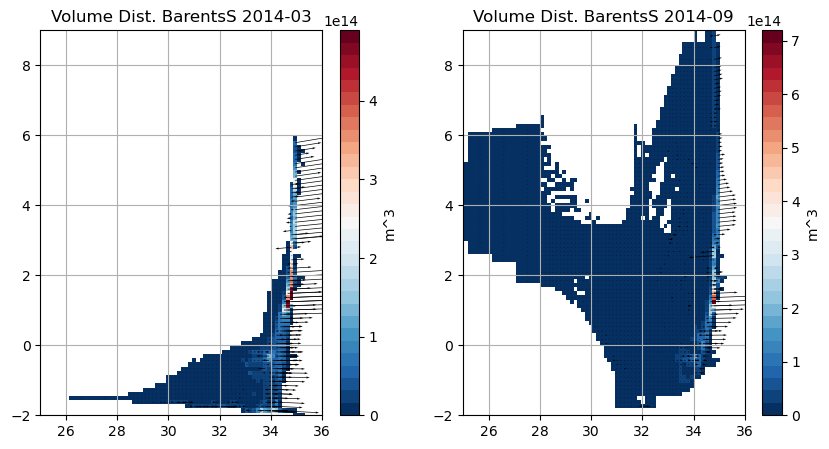

In [28]:
# try to plot an example
fig = plt.figure(figsize=(10,5))

# March
ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,mydata_test_m1,cmap=cmap,vmin = .001)
ax.quiver(Sbincent,Tbincent,distrADVx_SLT[m],distrADVx_TH[m],scale=5e10)    # in units of m^3/s
plt.colorbar(cb,label="m^3")
ax.set_title("Volume Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

# September
ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,mydata_test_m2,cmap=cmap,vmin = .001)
ax.quiver(Sbincent,Tbincent,distrADVx_SLT[s],distrADVx_TH[s],scale=5e10)    # in units of m^3/s
plt.colorbar(cb,label="m^3")
ax.set_title("Volume Dist. " + strb[iB] + " " + datetimes[s].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()

# plt.title(strb[iB])

plt.savefig(path + strb[iB] + "_ADVx_comparison.png",dpi=300)

/tmp/ipykernel_353105/4077319085.py:5: RuntimeWarning: Mean of empty slice
  data = np.nanmean(ADVx_SLT[m],axis=0)
/tmp/ipykernel_353105/4077319085.py:12: RuntimeWarning: Mean of empty slice
  data = np.nanmean(ADVx_SLT[s],axis=0)


(400.0, 600.0)

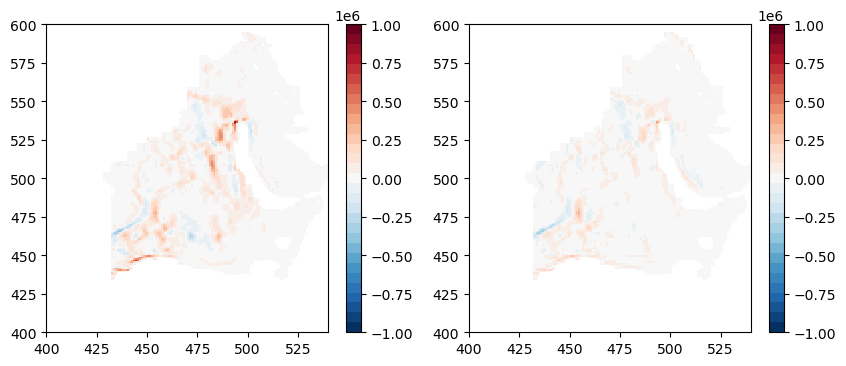

In [26]:
# quickly, does this make sense with the depth-mean advection we see in xyz? Yes!
fig = plt.figure()

ax = plt.subplot(121)
data = np.nanmean(ADVx_SLT[m],axis=0)
cb = ax.pcolormesh(get_aste_tracer(data*mymsk_iB[0],nfx,nfy)[0],cmap=cmap,vmin=-1e6,vmax=1e6)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

ax = plt.subplot(122)
data = np.nanmean(ADVx_SLT[s],axis=0)
cb = ax.pcolormesh(get_aste_tracer(data*mymsk_iB[0],nfx,nfy)[0],cmap=cmap,vmin=-1e6,vmax=1e6)
plt.colorbar(cb)
ax.set_xlim(400,540)
ax.set_ylim(400,600)

#### We need to sum the advective terms in xyz for each TS bin

In [83]:
# we already have distrADVx_SLT and distrADVx_TH, we need to repeat the process for y and z

# let's try to write a function such that we can create these diagrams for any average or file

def create_TS_mesh_vectors(attr_x,attr_y,attr_r,binned_theta,binned_salinity,nT,nS):
    '''
    Inputs:
        tsstr: the tsstr for the dataset
        itime: index in tsstr of what we want
        attr_x: the attribute we want in the x direction (ie ADVx_TH)
        attr_y: the attribute we want in y (ie ADVy_TH)
        attr_r: the attribute in z (ie ADVr_TH)
        nT, nS: number of cell centers

    Outputs:
        an array of shape nT, nS of the tendency values for a given basin or set of basins
    '''
    # initialize the TS mesh
    distr_attr = np.full((nT,nS),0.0)

    # get the indices where not nan so that we don't have to loop, hopefully faster
    indices = np.where(~np.isnan(binned_theta))
    if len(indices) == 2:
        y,x = indices[0],indices[1]
    else:
        z,y,x = indices[0],indices[1],indices[2]

    # loop over the z,y,x indices, grab the values from attr, and add them to the mesh
    # 2D case (ie gate)
    if len(indices) == 2:
        for i,j in zip(y,x):
            distr_attr[int(binned_salinity[i,j]),int(binned_theta[i,j])] += attr_x[i,j]
            distr_attr[int(binned_salinity[i,j]),int(binned_theta[i,j])] += attr_y[i,j]

    # 3D case (ie Basin)
    elif len(indices) == 3:
        for i,j,k in zip(z,y,x):
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr_x[i,j,k]
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr_y[i,j,k]
            distr_attr[int(binned_salinity[i,j,k]),int(binned_theta[i,j,k])] += attr_r[i,j,k]

    return distr_attr

In [84]:
# WRONG - WE SHOULD NOT BE SETTING ALL ZEROS TO NAN - only set the distr_attr array if the theta/salt indices not nan

# grab the advective terms and multiply by mymsk_iB
ADVx_TH_iB = ADVx_TH[m] * mymsk_iB
# ADVx_TH_iB[ADVx_TH_iB == 0] = np.nan
ADVy_TH_iB = ADVy_TH[m] * mymsk_iB
# ADVy_TH_iB[ADVy_TH_iB == 0] = np.nan
ADVr_TH_iB = ADVr_TH[m] * mymsk_iB
# ADVr_TH_iB[ADVr_TH_iB == 0] = np.nan

# also grab the salt values here
ADVx_SLT_iB = ADVx_SLT[m] * mymsk_iB
# ADVx_SLT_iB[ADVx_SLT_iB == 0] = np.nan
ADVy_SLT_iB = ADVy_SLT[m] * mymsk_iB
# ADVy_SLT_iB[ADVy_SLT_iB == 0] = np.nan
ADVr_SLT_iB = ADVr_SLT[m] * mymsk_iB
# ADVr_SLT_iB[ADVr_SLT_iB == 0] = np.nan

# grab the basin bin values
binned_theta_iB = binned_theta[m] * mymsk_iB
binned_salinity_iB = binned_salinity[m] * mymsk_iB

In [85]:
# try to run the function
distr_TH_iB = create_TS_mesh_vectors(ADVx_TH_iB,ADVy_TH_iB,ADVr_TH_iB,binned_theta_iB,binned_salinity_iB,nT,nS)
distr_SLT_iB = create_TS_mesh_vectors(ADVx_SLT_iB,ADVy_SLT_iB,ADVr_SLT_iB,binned_theta_iB,binned_salinity_iB,nT,nS)
# and this is so much faster than the looping we did before!

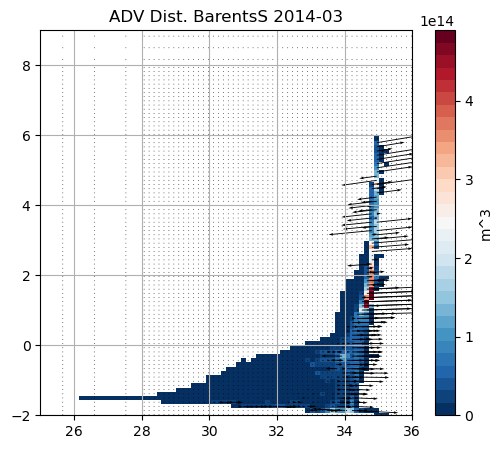

In [90]:
# try to plot an example
fig = plt.figure(figsize=(6,5))

# March
ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin,Tbin,mydata_test_m1,cmap=cmap,vmin = .001)
ax.quiver(Sbincent,Tbincent,distr_SLT_iB,distr_TH_iB,scale=1e9)    # in units of m^3/s
plt.colorbar(cb,label="m^3")
ax.set_title("ADV Dist. " + strb[iB] + " " + datetimes[m].strftime("%Y-%m"))
ax.set_xlim(25,36)
ax.set_ylim(-2,9)
ax.grid()